In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from glob import glob

from thesis.io import gyre, fgong
from thesis.physics import sound_speed, acoustic_depth
from thesis.calculus import differentiate

from glitchpy.supportGlitch import smoothComponent, totalGlitchSignal, glitchSignal, averageAmplitudes
from glitchpy.supportGlitch import fit

In [2]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
gong = fgong.load_fgong(filename)
gong

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [3]:
summary_filename = os.path.join(root_path, profile_name, "summary.h5")
detail_filenames = glob(os.path.join(root_path, profile_name, "detail*"))

pulse = gyre.load_output(summary_filename, detail_filenames)
pulse

<xarray.Dataset>
Dimensions:  (n_pg: 36, l: 3, x: 1046)
Coordinates:
  * n_pg     (n_pg) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
  * l        (l) int64 0 1 2
  * x        (x) float64 0.0 0.0009072 0.001143 0.00144 ... 1.001 1.001 1.001
Data variables:
    E_norm   (n_pg, l) float64 0.005267 nan 0.002007 ... 8.809e-09 nan nan
    freq     (n_pg, l) complex128 (255.42893986791924+0j) ... (nan+nanj)
    omega    (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As       (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2      (x, n_pg, l) float64 125.5 nan 125.5 125.5 ... 5.896e+03 nan nan
    c_1      (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
    xi_r     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
Attributes:
    freq_units:  UHZ
    label:

In [4]:
data = gong.merge(pulse, combine_attrs="drop_conflicts")
data

<xarray.Dataset>
Dimensions:       (x: 1046, n_pg: 36, l: 3)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
  * n_pg          (n_pg) int64 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
  * l             (l) int64 0 1 2
Data variables: (12/44)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    omega         (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As            (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2           (x, n_pg, l) float64 125.5 nan 125.5 ... 5.896e+03 nan nan
    c_1           (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
    xi_r          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
Attributes: (12/17)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08
    freq_units:      UHZ
    label:

In [5]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


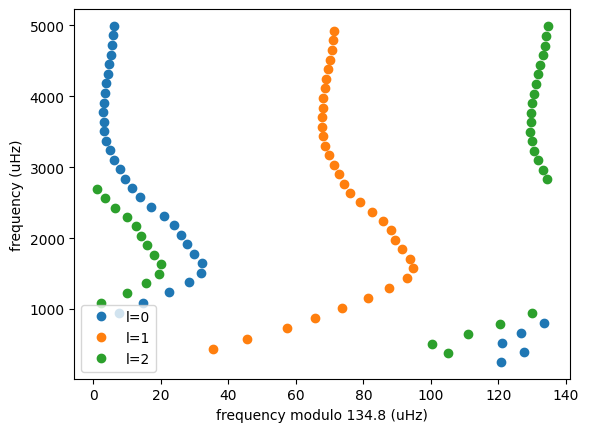

In [6]:
fig = plt.figure()

freq_mod = data.freq.real%nu0
for j in data.l:
    plt.plot(freq_mod.sel(l=j), data.freq.real.sel(l=j), 'o', color=f'C{j:d}', label=f'l={j:d}')
#     plt.plot(freq_mod.sel(l=j)-nu0, ds.freq.real.sel(l=j), 'o', color=f'C{j:d}')

plt.xlabel(f'frequency modulo {nu0:.1f} (uHz)')
plt.ylabel('frequency (uHz)')
plt.legend();

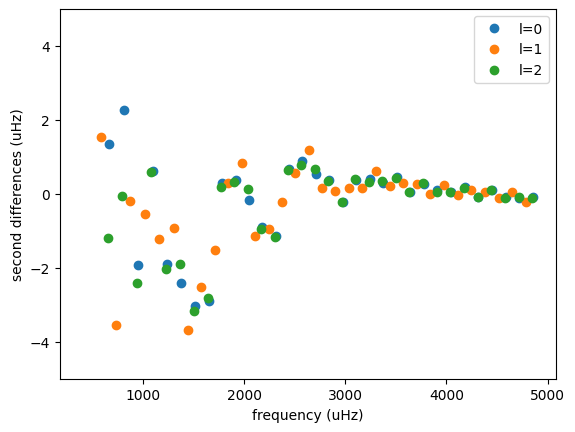

In [7]:
plt.figure()

d2nu = data.freq.real[:-2].values - 2 * data.freq.real[1:-1].values + data.freq.real[2:].values

for j in range(3):
    plt.plot(data.freq.real[1:-1, j], d2nu[:, j], 'o', color=f'C{j:d}', label=f'l={data.l[j]:d}')

plt.xlabel('frequency (uHz)')
plt.ylabel('second differences (uHz)')
plt.ylim(-5, 5)
plt.legend();

In [8]:
def get_inputs(data, n, sigma=1.0, num_of_l=1):
    """Get frequency array in format required for GlitchPy."""
    l = list(range(num_of_l))
    d = data.sel(n_pg=n, l=l).stack(k=("l", "n_pg"))
    freq = np.stack(
        [
            d.l.values,
            d.n_pg.values,
            d.freq.real.values,
            sigma*np.ones(d.freq.shape)
        ],
        axis=-1
    )
    
    # Number of n for each l
    num_of_n = np.zeros(num_of_l, dtype=int)
    for i in range (num_of_l):
        num_of_n[i] = len(freq[np.rint(freq[:, 0]) == i, 0])
    
    # Delta nu
    coefs = np.polyfit(freq[freq[:, 0]<0.5, 1], freq[freq[:, 0]<0.5, 2], 1)
    delta_nu = coefs[0]

    return freq[~np.isnan(freq).any(axis=1)], num_of_n, delta_nu

In [329]:
name = "best"

In [332]:
# Worst 
# n = np.arange(17, 23)
# sigma = 1.0

# Better
# n = np.arange(14, 26)
# sigma = 1e-1

# Best
n = np.arange(11, 29)
sigma = 1e-2

num_of_l = 1
freq, num_of_n, delta_nu = get_inputs(data, n, sigma=sigma, num_of_l=num_of_l)

freq_obs = freq.copy()
freq_obs[:, 2] += freq_obs[:, 3] * np.random.normal(size=freq_obs.shape[0])  # add noise

<ErrorbarContainer object of 3 artists>

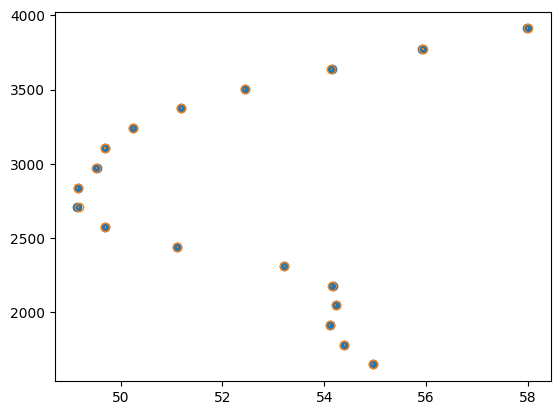

In [333]:
fig, ax = plt.subplots()

ax.plot(freq[:, 2]%delta_nu, freq[:, 2], "o")
ax.errorbar(freq_obs[:, 2]%delta_nu, freq_obs[:, 2], xerr=freq_obs[:, 3], fmt="o", markerfacecolor="none")
# ax.plot(nu%delta_nu, nu, "o", markerfacecolor="none")
# ax.set_xlim(50, 60)

In [397]:
tol_grad = 1e-3
if name == "better":
    tol_grad = 1e-2
elif name == "best":
    tol_grad = 1e-1

In [375]:
param, chi2, reg, ier, ratio = fit(
    freq_obs, num_of_n, delta_nu, n_rln=1000, tol_grad=tol_grad, regu_param=7.0, n_guess=200,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:43<00:00,  9.70it/s]


In [376]:
param_names = [
    "a0",
    "a1",
    "a2",
    "a3",
    "a4",
    "a_cz",
    "tau_cz",
    "phi_cz",
    "a_he",
    "delta_he",
    "tau_he",
    "phi_he",
]

In [377]:
samples = np.concatenate((param, chi2[:, None], reg[:, None]), axis=1)
samples_names = param_names + ["chi2", "reg"]

In [378]:
df = pd.DataFrame(samples, columns=samples_names)
df.head()

,a0,a1,a2,a3,a4,a_cz,tau_cz,phi_cz,a_he,delta_he,tau_he,phi_he,chi2,reg
0,79.222749,158.488908,-2.099408,0.069804,-0.000801,8.287548e+05,903.066457,0.456817,0.002229,65.312259,596.141765,3.643971,441.981723,10.482530
1,64.556771,161.630773,-2.344342,0.078069,-0.000903,5.808669e+06,1885.695678,1.789925,0.001811,61.491397,623.262897,2.785766,1137.170730,13.003291
2,76.452978,159.143727,-2.154426,0.071775,-0.000826,6.062408e+05,2550.131178,2.207151,0.002155,64.144140,614.639554,3.055734,737.539060,11.040069
3,75.853556,159.283685,-2.166070,0.072189,-0.000832,6.194597e+05,2548.015087,2.257085,0.002218,64.632099,615.460914,3.028872,868.347306,11.159942
4,63.641663,161.809815,-2.357284,0.078479,-0.000908,5.546307e+06,1886.317857,1.771323,0.001749,61.064765,624.522074,2.741064,1263.775070,13.139583


In [379]:
filename = os.path.expanduser(f"~/OneDrive/Data/alexlyttle/thesis/v19-glitch-samples-{name}.csv")
df.to_csv(filename)

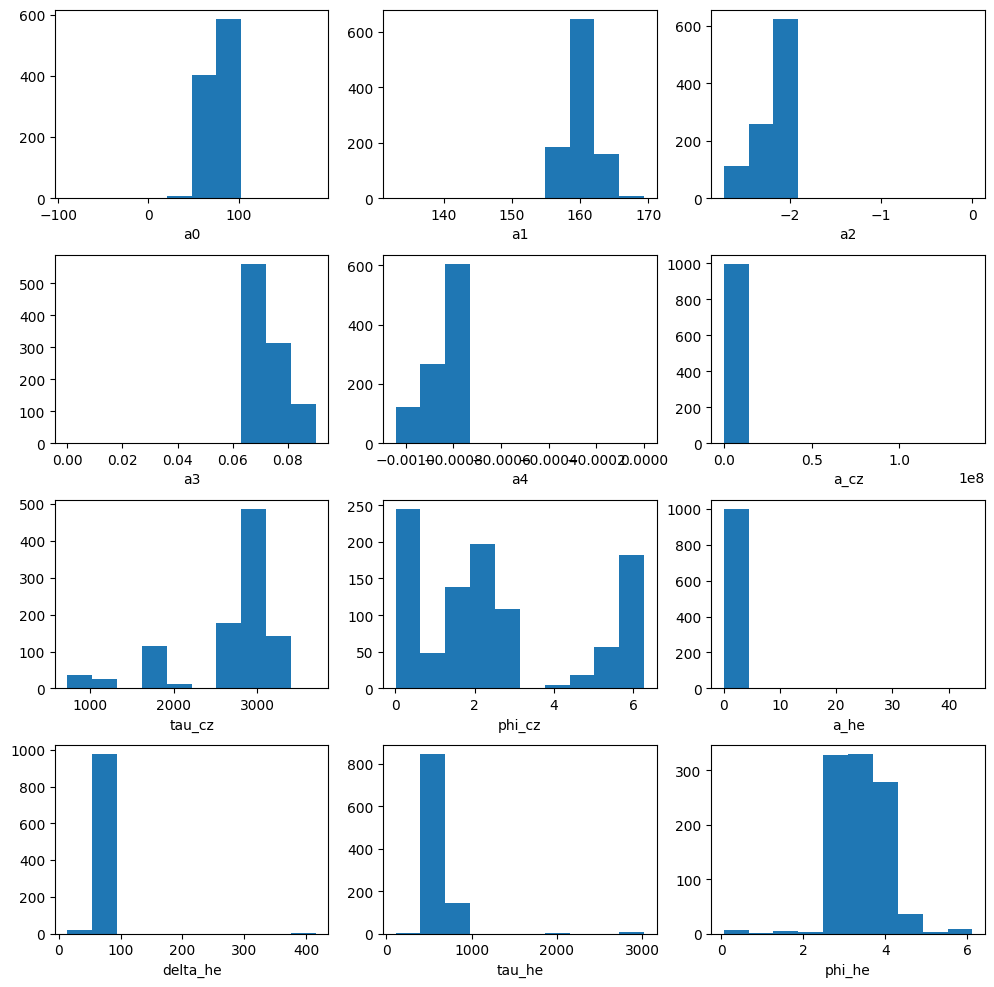

In [380]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12), gridspec_kw={"hspace": 0.3})

for i, ax in enumerate(axes.ravel()):
    ax.hist(param[:-1, i])
    ax.set_xlabel(param_names[i])

In [382]:
nu_max_sol = 3090.0
g_sol = 10**4.44
teff_sol = 5777.0

g = data.G * data.M / data.R**2
nu_max = nu_max_sol * g / g_sol * (data.Teff/teff_sol)**-0.5

In [383]:
def helium_at_nu(param, nu):
    return param[:, -4] * nu * np.exp(- 8e-12 * np.pi**2 * param[:, -3]**2 * nu**2)

In [384]:
amp_numax = helium_at_nu(param, nu_max)

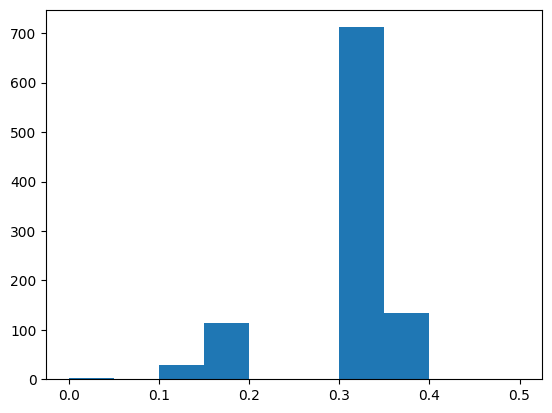

In [385]:
plt.hist(amp_numax, range=(0., 0.5));

In [386]:
def _oscillation(nu, tau, phi):
    return np.sin(4 * np.pi * tau * nu + phi)

def poly(p, x):
    powers = np.arange(p.shape[-1])
    return np.sum(p*x[..., None]**powers, axis=-1)

def smooth_component(param, n, npoly_params=5):
    return np.apply_along_axis(
        poly, 
        -1,
        param[..., :npoly_params], 
        n,
    )

def helium_amp(param, nu):
    return param[..., -4, None] * nu * np.exp(- 8e-12 * np.pi**2 * param[..., -3, None]**2 * nu**2)

def helium_glitch(param, nu):
    return helium_amp(param, nu) * _oscillation(nu, 1e-6*param[..., -2, None], param[..., -1, None])

def bcz_amp(param, nu):
    return param[..., -7, None] / nu**2

def bcz_glitch(param, nu):
    return bcz_amp(param, nu) * _oscillation(nu, 1e-6*param[..., -6, None], param[..., -5, None])

def glitch(param, nu):
    return helium_glitch(param, nu) + bcz_glitch(param, nu)

In [387]:
from corner import corner

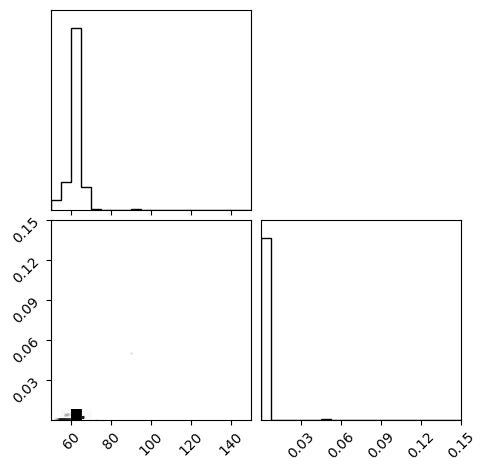

In [388]:
corner(param[:, [-3, -4]], range=[(50, 150), (0, 0.15)]);

In [389]:
nu_sm = smooth_component(param, freq[:, 1])
dnu = glitch(param, nu_sm)
nu = nu_sm + dnu

In [390]:
thin = 20

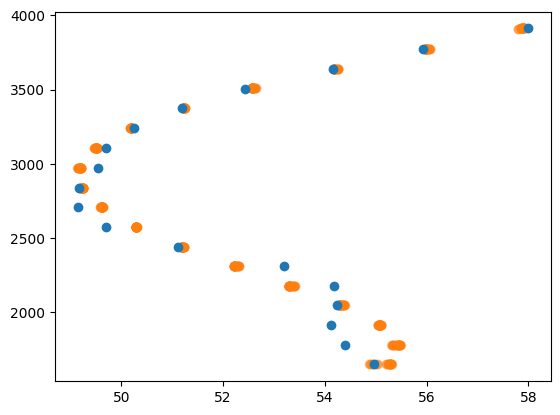

In [391]:
fig, ax = plt.subplots()

ax.errorbar(freq[:, 2]%delta_nu, freq[:, 2], xerr=freq[:, 3], fmt="o")
ax.plot(nu_sm[::thin]%delta_nu, nu_sm[::thin], "o", color="C1", alpha=0.2)
# ax.plot(nu%delta_nu, nu, "o", markerfacecolor="none")
# ax.set_xlim(50, 60)

In [392]:
num_points = 501
nu_pred = np.linspace(freq[:, 2].min(), freq[:, 2].max(), num_points)
dnu_pred = glitch(param, nu_pred)

In [393]:
dnu_he_pred = helium_glitch(param[-1, :], nu_pred)
dnu_cz_pred = bcz_glitch(param[-1, :], nu_pred)

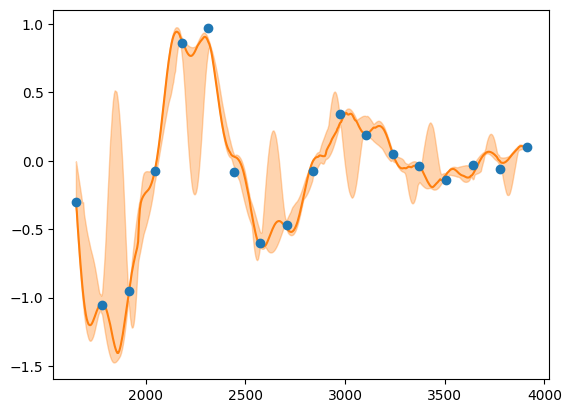

In [394]:
fig, ax = plt.subplots()
ax.errorbar(freq[:, 2], freq[:, 2] - np.median(nu_sm, axis=0), yerr=freq[:, 3], fmt="o", color="C0", label="data")
# ax.plot(nu_pred[::thin].T, dnu_pred[::thin].T, alpha=0.2, color="C0")


dnu_med = np.median(dnu_pred, axis=0)
dnu_lower, dnu_upper = np.quantile(dnu_pred, [.16, .84], axis=0)

ax.plot(nu_pred, dnu_med, color="C1")
ax.fill_between(nu_pred, dnu_lower, dnu_upper, color="C1", alpha=0.33)
# ax.plot(nu_pred, dnu_he_pred, label="He")
# ax.plot(nu_pred, dnu_cz_pred, label="CZ")
# ax.set_ylim(-5, 5)
# ax.legend();

Difference between prediciton and truth

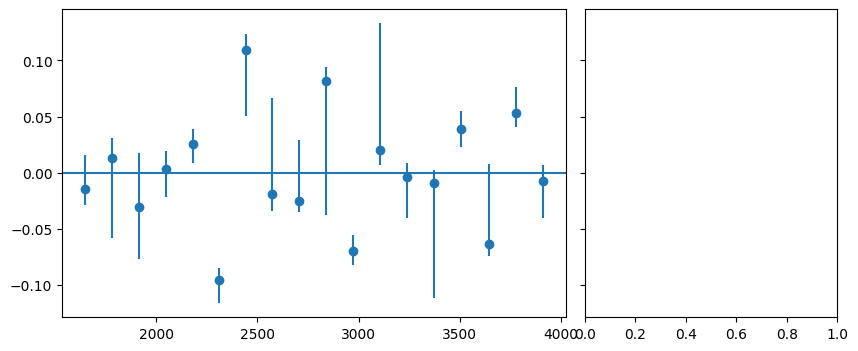

In [395]:
res = nu - freq[:, 2]
res_med = np.median(res, axis=0)
res_unc = np.abs(res_med - np.quantile(res, [.16, .84], axis=0))

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True,
                         gridspec_kw={"wspace": 0.05, "width_ratios": [2, 1]})

ax = axes[0]
ax.errorbar(freq[:, 2], res_med, yerr=res_unc, fmt="o")
# for l in range(num_of_l):
#     mask = freq[:, 0] == l
#     ax.plot(nu[mask], res[mask], "o", label=l)
    

ax.axhline()
# ax.legend()

ax = axes[1]
# ax.hist(res.flatten(), orientation="horizontal", color="k", histtype="step");

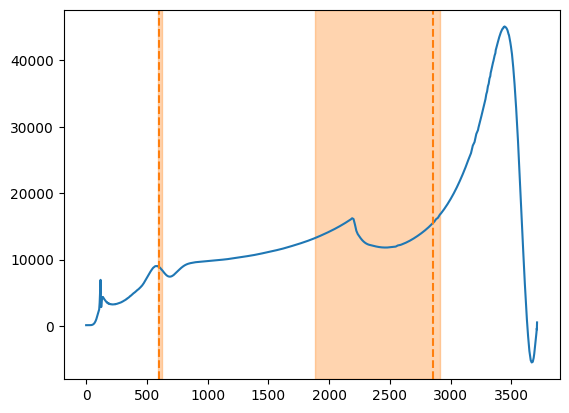

In [396]:
plt.plot(data.tau, differentiate(data.cs, data.tau))

plt.axvline(np.median(param[:, -2]), c="C1", ls="--")
plt.axvline(np.median(param[:, -6]), c="C1", ls="--")

plt.axvspan(*np.quantile(param[:, -2], [.16, .84]), color="C1", alpha=0.33)
plt.axvspan(*np.quantile(param[:, -6], [.16, .84]), color="C1", alpha=0.33)